1. Load the packages

In [ ]:
from torch.utils.data import Dataset,DataLoader,TensorDataset
from sklearn.datasets import fetch_openml
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plot
import torch
import torch.nn as nn
from torch.autograd.function import Function
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from  torch.utils.data import DataLoader
import torch.optim.lr_scheduler as lr_scheduler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

2. Define the function used to load MNIST and USPS data splits



You need to download[ MNIST-USPS data splits](https://github.com/samotiian/CCSA) generated in [1] to run this code. Then: 


2.1. If you run the code on Colab, you will need to put these splits in the corresponding folder of your [Google Drive](https://drive.google.com/drive/u/0/my-drive).


2.2. If you run the code locally, you will need to put these splits in the corresponding folder of your device.



[1] Motiian, S., Piccirilli, M., Adjeroh, D. A., & Doretto, G. (2017). Unified deep supervised domain adaptation and generalization. In Proceedings of the IEEE international conference on computer vision (pp. 5715-5725).

In [ ]:
# The path where you put the data.
initial_path='/content/drive/MyDrive/MINIST domain adaptation/CCSA-master/row_data/'

Mounted at /content/drive


In [ ]:
# The function used to load the data, refered to:
##
#Motiian, S., Piccirilli, M., Adjeroh, D. A., & Doretto, G. (2017). 
#Unified deep supervised domain adaptation and generalization. 
#In Proceedings of the IEEE international conference on computer vision (pp. 5715-5725).
##

def read_data(domain_adaptation_task,repetition,sample_per_class):
    UM  = domain_adaptation_task
    cc  = repetition
    SpC = sample_per_class
    if UM != 'MNIST_to_USPS':
        if UM != 'USPS_to_MNIST':
            raise Exception('domain_adaptation_task should be either MNIST_to_USPS or USPS_to_MNIST')


    if cc <0 or cc>10:
        raise Exception('number of repetition should be between 0 and 9.')

    if SpC <1 or SpC>7:
            raise Exception('number of sample_per_class should be between 1 and 7.')

    X_train_target=np.load(initial_path + UM + '_X_train_target_repetition_' + str(cc) + '_sample_per_class_' + str(SpC) + '.npy')
    y_train_target=np.load(initial_path + UM + '_y_train_target_repetition_' + str(cc) + '_sample_per_class_' + str(SpC) + '.npy')

    X_train_source=np.load(initial_path + UM + '_X_train_source_repetition_' + str(cc) + '_sample_per_class_' + str(SpC) + '.npy')
    y_train_source=np.load(initial_path + UM + '_y_train_source_repetition_' + str(cc) + '_sample_per_class_' + str(SpC) + '.npy')

    X_test = np.load(initial_path + UM + '_X_test_target_repetition_' + str(cc) + '_sample_per_class_' + str(SpC)+'.npy')
    y_test = np.load(initial_path + UM + '_y_test_target_repetition_' + str(cc) + '_sample_per_class_' + str(SpC)+'.npy')

    
    return X_train_target,y_train_target,X_train_source,y_train_source,X_test,y_test



3. Self-define layer and function center transfer loss (CTL)

In [ ]:
class CTL(nn.Module):
    def __init__(self, num_classes, feat_dim, size_average=True):
        super(CTL, self).__init__()
        self.centers = nn.Parameter(torch.randn(num_classes, feat_dim))
        self.centerlossfunc = CenterlossFunc.apply
        self.feat_dim = feat_dim
        self.size_average = size_average

    def forward(self, label, flip_label, domain_label,feat):
        batch_size = feat.size(0)
        feat = feat.view(batch_size, -1)
        # To check the dim of centers and features
        if feat.size(1) != self.feat_dim:
            raise ValueError("Center's dim: {0} should be equal to input feature's \
                            dim: {1}".format(self.feat_dim,feat.size(1)))
        batch_size_tensor = feat.new_empty(1).fill_(batch_size if self.size_average else 1)
        loss = self.centerlossfunc(feat, label,flip_label, domain_label,self.centers, batch_size_tensor)
        return loss


class CenterlossFunc(Function):
    @staticmethod
    def forward(ctx, feature, label,flip_label, domain_label,centers, batch_size):
        ctx.save_for_backward(feature, label,flip_label, domain_label,centers, batch_size)
        centers_batch = centers.index_select(0, flip_label.long())

        domain_counts = centers.new_zeros(2)
        domain_ones = centers.new_ones(domain_label.size(0))
        domain_counts = domain_counts.scatter_add_(0, domain_label.long(), domain_ones)+0.0001
        domain_counts = torch.index_select(domain_counts, 0, domain_label.int())  

        return ((feature - centers_batch).pow(2)/domain_counts.view(-1, 1)).sum() / 2.0 / batch_size

    @staticmethod
    def backward(ctx, grad_output):
        feature,label,flip_label,domain_label,centers,batch_size = ctx.saved_tensors
        flip_centers_batch = centers.index_select(0, flip_label.long())
        flip_diff=flip_centers_batch-feature

        domain_counts = centers.new_zeros(2)
        domain_ones = centers.new_ones(domain_label.size(0))
        domain_counts = domain_counts.scatter_add_(0, domain_label.long(), domain_ones)+0.0001
        domain_counts = torch.index_select(domain_counts, 0, domain_label.int())  
      


        centers_batch = centers.index_select(0, label.long())
        diff = centers_batch - feature
        # init every iteration
        counts = centers.new_ones(centers.size(0))
        ones = centers.new_ones(label.size(0))
        grad_centers = centers.new_zeros(centers.size())
        counts = counts.scatter_add_(0, label.long(), ones)-1+0.001

        grad_centers.scatter_add_(0, label.unsqueeze(1).expand(feature.size()).long(), diff)
        grad_centers = grad_centers/counts.view(-1, 1)
       
        return - grad_output * (flip_diff/domain_counts.view(-1, 1)) / batch_size, None, None,None,grad_centers / batch_size, None

#Testing function
def main(test_cuda=False):
    print('-'*80)
    device = torch.device("cuda" if test_cuda else "cpu")
    ct = CTL(20,2,size_average=True).to(device)
    y = torch.Tensor([0,0,2,1,3]).to(device)
    dola= torch.Tensor([0,0,1,1,0]).to(device)
    feat = torch.zeros(5,2).to(device).requires_grad_()
    print(list(ct.parameters()))
    
    print(ct.centers.grad)
    out = ct(y,y,dola,feat)
    print(out.item())
    out.backward()


if __name__ == '__main__':
    torch.manual_seed(999)
    if torch.cuda.is_available():
        main(test_cuda=True)

--------------------------------------------------------------------------------
[Parameter containing:
tensor([[-0.2528,  1.4072],
        [ 0.2910,  1.0365],
        [-0.9816, -3.4219],
        [ 1.4910,  0.2422],
        [ 1.4832, -0.3704],
        [ 0.0941,  2.1528],
        [ 0.6271, -1.1666],
        [-0.7862,  0.0759],
        [-0.0086, -0.6568],
        [-1.0011,  0.2992],
        [ 0.6396, -1.0857],
        [-1.6153,  1.5635],
        [ 0.8194,  0.6117],
        [ 0.7602,  1.4788],
        [ 1.9647,  0.9414],
        [ 0.3883, -0.3957],
        [ 0.5920, -2.8563],
        [-0.4750, -0.9978],
        [ 0.0489,  0.9250],
        [-1.2278, -0.9470]], device='cuda:0', requires_grad=True)]
None
0.9038917422294617


4. Define LetNet++ for MNIST-USPS

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1_1 = nn.Conv2d(1, 32, kernel_size=5, padding=2)
        self.prelu1_1 = nn.PReLU()
        self.conv1_2 = nn.Conv2d(32, 32, kernel_size=5, padding=2)
        self.prelu1_2 = nn.PReLU()
        self.conv2_1 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.prelu2_1 = nn.PReLU()
        self.conv2_2 = nn.Conv2d(64, 64, kernel_size=5, padding=2)
        self.prelu2_2 = nn.PReLU()
        self.conv3_1 = nn.Conv2d(64, 128, kernel_size=5, padding=2)
        self.prelu3_1 = nn.PReLU()
        self.conv3_2 = nn.Conv2d(128, 128, kernel_size=5, padding=2)
        self.prelu3_2 = nn.PReLU()
        self.preluip1 = nn.PReLU()
        self.ip1 = nn.Linear(128*2*2, 84)
        self.ip2 = nn.Linear(84, 10, bias=False)


    def forward(self, x):
        x = self.prelu1_1(self.conv1_1(x))
        x = self.prelu1_2(self.conv1_2(x))
        x = F.max_pool2d(x,2)
        x = self.prelu2_1(self.conv2_1(x))
        x = self.prelu2_2(self.conv2_2(x))
        x = F.max_pool2d(x,2)
        x = self.prelu3_1(self.conv3_1(x))
        x = self.prelu3_2(self.conv3_2(x))
        x = F.max_pool2d(x,2)
        x = x.view(-1, 128*2*2)
        ip1 = self.preluip1(self.ip1(x))
        ip2 = self.ip2(ip1)
        return ip1, F.log_softmax(ip2, dim=1)



5. Define the training in one epoch

In [ ]:
#Activate GPU

use_cuda = torch.cuda.is_available() and True
device = torch.device("cuda" if use_cuda else "cpu")
def train(epoch,loss_weight,train_loader,model,nllloss,ctl,optimizer4nn,optimzer4center,x_test,y_test):
  print ("Training... Epoch = %d" % epoch)
  ip1_loader = []
  idx_loader = []

  for data, target,good_ord,flip_ord,domain_label in train_loader:
    data, target,good_ord,flip_ord,domain_label = data.to(device), target.to(device),good_ord.to(device), flip_ord.to(device),domain_label.to(device)

    ip1, pred = model(data)
    loss = nllloss(pred, target) + loss_weight * ctl(good_ord, flip_ord,domain_label,ip1)

    optimizer4nn.zero_grad()
    optimzer4center.zero_grad()

    loss.backward()

    optimizer4nn.step()
    optimzer4center.step()
    ip1_loader.append(ip1)
    idx_loader.append((target))
  feat = torch.cat(ip1_loader, 0)
  labels = torch.cat(idx_loader, 0)


6. Define the training function

In [ ]:

def trainss(repetition,sample_per_class,weightss):
  repetition=repetition
  sample_per_class=sample_per_class
  # MNIST_to_USPS
  X_train_target,y_train_target,X_train_source,y_train_source,X_test,y_test=read_data('USPS_to_MNIST',repetition,sample_per_class)

  domain_label=np.hstack((np.zeros(len(y_train_source)),np.ones(len(y_train_target))))

  x_train=np.vstack((X_train_source,X_train_target))
  y_train=np.hstack((y_train_source,y_train_target))

  good_order=np.hstack((y_train_source,y_train_target+10))
  flip_order=np.hstack((y_train_source+10,y_train_target))


  x_train=torch.from_numpy(x_train).reshape(-1,1,16,16)
  y_train=torch.from_numpy(y_train)
  x_test=torch.from_numpy(X_test).reshape(-1,1,16,16)
  y_test=torch.from_numpy(y_test)

  good_order=torch.from_numpy(good_order)
  flip_order=torch.from_numpy(flip_order)
  domain_label=torch.from_numpy(domain_label)



  x_train=x_train.float()
  x_test=x_test.float()
  y_train=y_train.long()
  y_test=y_test.long()

  good_order=good_order.long()
  flip_order=flip_order.long()
  domain_label=domain_label.long()
  # form the dataset
  train_dataset=TensorDataset(x_train,y_train,good_order,flip_order,domain_label)
  val_dataset=TensorDataset(x_test,y_test)
  train_loader= DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
  test_loader = DataLoader(val_dataset, batch_size=64, shuffle=True, num_workers=2)

  model = Net().to(device)
  nllloss = nn.CrossEntropyLoss().to(device) #Softmax
  loss_weight =  weightss #Trade-off
  ctl = CTL(20, 84).to(device)
  optimizer4nn = optim.Adam(model.parameters(),lr=0.001,weight_decay=0)
  sheduler = lr_scheduler.StepLR(optimizer4nn,20,gamma=0.8)
  optimzer4center = optim.Adam(ctl.parameters(), lr =0.5)
  best=[0]
  eps=0
  for epoch in range(100):
    train(epoch+1, loss_weight,train_loader,model,nllloss,ctl,optimizer4nn,optimzer4center,x_test,y_test)
  print("Training finishes...............")
  return model


7. Visualization function

In [ ]:
def visualize(srcfeature,srclabel,tarfeature, tarlabel):
    fea=np.vstack((srcfeature,tarfeature))
    feature = TSNE(n_components=2, learning_rate='auto',init='random').fit_transform(fea)
    src=feature[:len(srcfeature)]
    tar=feature[len(srcfeature):]

    plt.ion()
    c = ['#ff0000', '#ffff00', '#00ff00', '#00ffff', '#0000ff',
         '#ff00ff', '#990000', '#999900', '#009900', '#000000']    
    plt.clf()
    for i in range(10):
        plt.scatter(src[srclabel == i, 0], src[srclabel == i, 1], marker='.', c=c[i])
    for i in range(10):
        plt.scatter(tar[tarlabel == i, 0], tar[tarlabel == i, 1], marker='^',c=c[i],edgecolor='black', linewidth=0.2,alpha=0.5)


    plt.savefig('/'+"figure.jpg", format='jpg', dpi=1200)
    plt.draw()

7. Perform model training, another selection of data, and visualization, **when N=1**.

Training... Epoch = 1
Training... Epoch = 2
Training... Epoch = 3
Training... Epoch = 4
Training... Epoch = 5
Training... Epoch = 6
Training... Epoch = 7
Training... Epoch = 8
Training... Epoch = 9
Training... Epoch = 10
Training... Epoch = 11
Training... Epoch = 12
Training... Epoch = 13
Training... Epoch = 14
Training... Epoch = 15
Training... Epoch = 16
Training... Epoch = 17
Training... Epoch = 18
Training... Epoch = 19
Training... Epoch = 20
Training... Epoch = 21
Training... Epoch = 22
Training... Epoch = 23
Training... Epoch = 24
Training... Epoch = 25
Training... Epoch = 26
Training... Epoch = 27
Training... Epoch = 28
Training... Epoch = 29
Training... Epoch = 30
Training... Epoch = 31
Training... Epoch = 32
Training... Epoch = 33
Training... Epoch = 34
Training... Epoch = 35
Training... Epoch = 36
Training... Epoch = 37
Training... Epoch = 38
Training... Epoch = 39
Training... Epoch = 40
Training... Epoch = 41
Training... Epoch = 42
Training... Epoch = 43
Training... Epoch = 

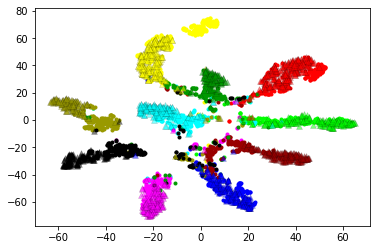

In [ ]:
rep=2
sample_per_cl=1 #N=1
weightss=0.75
#Model training
model_1=trainss(rep,sample_per_cl,weightss)


# Another selection of data
X_train_target,y_train_target,X_train_source,y_train_source,X_test,y_test=read_data('MNIST_to_USPS',3,4)
source_x=X_train_source
source_y=y_train_source
target_x=X_test
target_y=y_test
source_x=torch.from_numpy(source_x).reshape(-1,1,16,16)
target_x=torch.from_numpy(target_x).reshape(-1,1,16,16)
source_x=source_x.float()
target_x=target_x.float()
source_feature= model_1(source_x.to(device))[0].data.cpu().numpy()
target_feature= model_1(target_x.to(device))[0].data.cpu().numpy()

# Visualization
visualize(source_feature,source_y,target_feature,target_y)

8. Perform model training, another selection of data, and visualization, **when N=4**.

Training... Epoch = 1
Training... Epoch = 2
Training... Epoch = 3
Training... Epoch = 4
Training... Epoch = 5
Training... Epoch = 6
Training... Epoch = 7
Training... Epoch = 8
Training... Epoch = 9
Training... Epoch = 10
Training... Epoch = 11
Training... Epoch = 12
Training... Epoch = 13
Training... Epoch = 14
Training... Epoch = 15
Training... Epoch = 16
Training... Epoch = 17
Training... Epoch = 18
Training... Epoch = 19
Training... Epoch = 20
Training... Epoch = 21
Training... Epoch = 22
Training... Epoch = 23
Training... Epoch = 24
Training... Epoch = 25
Training... Epoch = 26
Training... Epoch = 27
Training... Epoch = 28
Training... Epoch = 29
Training... Epoch = 30
Training... Epoch = 31
Training... Epoch = 32
Training... Epoch = 33
Training... Epoch = 34
Training... Epoch = 35
Training... Epoch = 36
Training... Epoch = 37
Training... Epoch = 38
Training... Epoch = 39
Training... Epoch = 40
Training... Epoch = 41
Training... Epoch = 42
Training... Epoch = 43
Training... Epoch = 

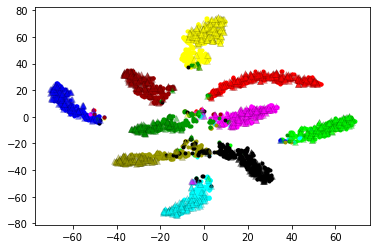

In [ ]:
rep=2
sample_per_cl=4 #N=4
weightss=0.75

#Model training
model_4=trainss(rep,sample_per_cl,weightss)

# Another selection of data
X_train_target,y_train_target,X_train_source,y_train_source,X_test,y_test=read_data('MNIST_to_USPS',3,4)
source_x=X_train_source
source_y=y_train_source
target_x=X_test
target_y=y_test
source_x=torch.from_numpy(source_x).reshape(-1,1,16,16)
target_x=torch.from_numpy(target_x).reshape(-1,1,16,16)
source_x=source_x.float()
target_x=target_x.float()
source_feature= model_4(source_x.to(device))[0].data.cpu().numpy()
target_feature= model_4(target_x.to(device))[0].data.cpu().numpy()

# Visualization
visualize(source_feature,source_y,target_feature,target_y)

9. Perform model training, another selection of data, and visualization, **when N=7**.

Training... Epoch = 1
Training... Epoch = 2
Training... Epoch = 3
Training... Epoch = 4
Training... Epoch = 5
Training... Epoch = 6
Training... Epoch = 7
Training... Epoch = 8
Training... Epoch = 9
Training... Epoch = 10
Training... Epoch = 11
Training... Epoch = 12
Training... Epoch = 13
Training... Epoch = 14
Training... Epoch = 15
Training... Epoch = 16
Training... Epoch = 17
Training... Epoch = 18
Training... Epoch = 19
Training... Epoch = 20
Training... Epoch = 21
Training... Epoch = 22
Training... Epoch = 23
Training... Epoch = 24
Training... Epoch = 25
Training... Epoch = 26
Training... Epoch = 27
Training... Epoch = 28
Training... Epoch = 29
Training... Epoch = 30
Training... Epoch = 31
Training... Epoch = 32
Training... Epoch = 33
Training... Epoch = 34
Training... Epoch = 35
Training... Epoch = 36
Training... Epoch = 37
Training... Epoch = 38
Training... Epoch = 39
Training... Epoch = 40
Training... Epoch = 41
Training... Epoch = 42
Training... Epoch = 43
Training... Epoch = 

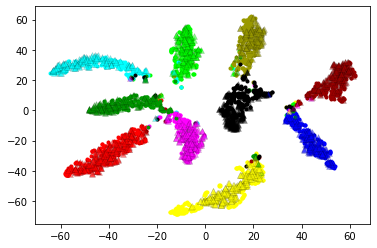

In [ ]:
rep=2
sample_per_cl=7 #N=7
weightss=0.75

#Model training
model_7=trainss(rep,sample_per_cl,weightss)

# Another selection of data
X_train_target,y_train_target,X_train_source,y_train_source,X_test,y_test=read_data('MNIST_to_USPS',3,4)
source_x=X_train_source
source_y=y_train_source
target_x=X_test
target_y=y_test
source_x=torch.from_numpy(source_x).reshape(-1,1,16,16)
target_x=torch.from_numpy(target_x).reshape(-1,1,16,16)
source_x=source_x.float()
target_x=target_x.float()
source_feature= model_7(source_x.to(device))[0].data.cpu().numpy()
target_feature= model_7(target_x.to(device))[0].data.cpu().numpy()

# Visualization
visualize(source_feature,source_y,target_feature,target_y)